In [1]:
import pandas as pd
import sklearn as sk
from datetime import datetime

now = datetime.now().strftime("%d/%m/%Y_%H:%M:%S")

print(f"notebook execution: {now}")

notebook execution: 08/02/2026_20:39:37


In [2]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Load predictions
df = pd.read_csv("../src/predictions_effv2s_42.csv")

y_true = df["true_label"]
y_pred = df["predicted_label"]
y_score = df["predicted_score"]

# Calculate metrics
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1": f1_score(y_true, y_pred),
    "ROC-AUC": roc_auc_score(y_true, y_score)
}

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print("Classification Metrics:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")
print(f"Confusion Matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")   

Classification Metrics:
Accuracy: 0.9991
Precision: 0.9994
Recall: 0.9985
F1: 0.9990
ROC-AUC: 1.0000
Confusion Matrix: TN=15475, FP=7, FN=17, TP=11661


In [3]:
from sklearn.metrics import roc_curve
import numpy as np

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
fnr = 1 - tpr
eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
print(f"EER: {eer:.4f}")   

EER: 0.0009


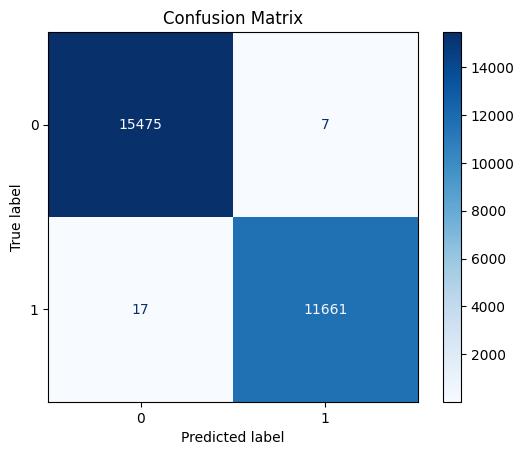

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
# plt.savefig("confusion_matrix.png")
plt.show()   

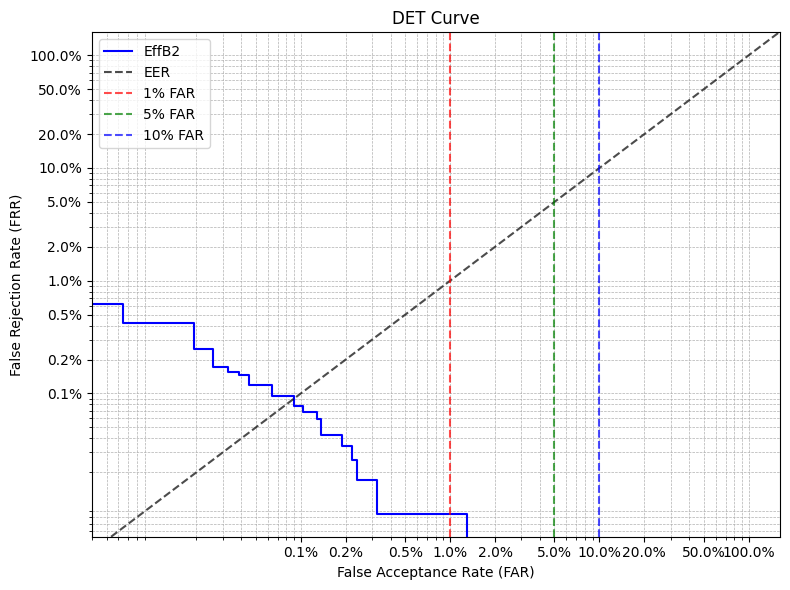

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import roc_curve

# Compute FPR, TPR, FNR
fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
fnr = 1 - tpr

# Compute EER
eer = fpr[np.nanargmin(np.abs(fnr - fpr))]

# Plot DET curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, fnr, label=f"EffB2", color="blue")

# Log scale with ISO-style ticks
ticks = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]
plt.xscale("log")
plt.yscale("log")
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Format axes
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1%}'))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f'{y:.1%}'))
plt.xlabel("False Acceptance Rate (FAR)")
plt.ylabel("False Rejection Rate (FRR)")
plt.title("DET Curve")

# Add vertical lines for operational points
plt.axline((0, 0), (1, 1), color='k', linestyle='--', alpha=0.7, label=f'EER')
plt.axvline(0.01, color='r', linestyle='--', alpha=0.7, label='1% FAR')
plt.axvline(0.05, color='g', linestyle='--', alpha=0.7, label='5% FAR')
plt.axvline(0.10, color='b', linestyle='--', alpha=0.7, label='10% FAR')

plt.legend()
plt.tight_layout()
plt.show()

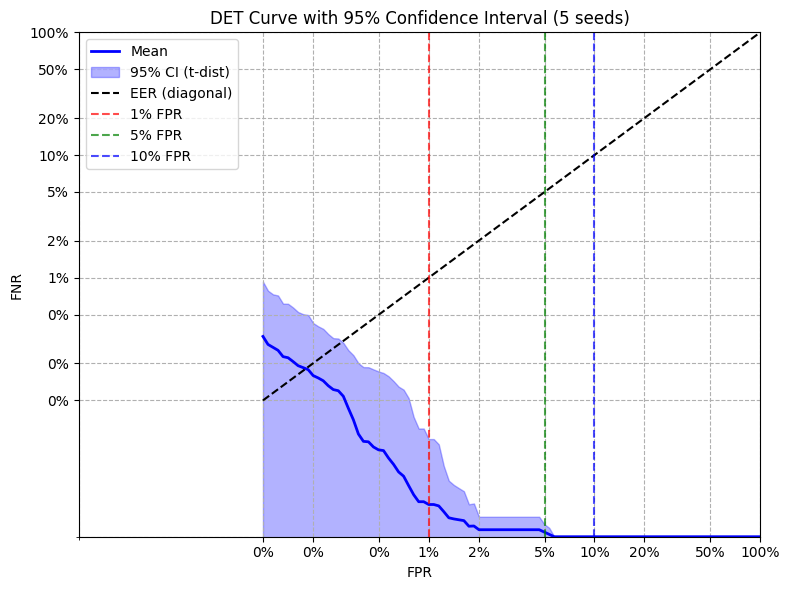

Mean EER: 0.0015 ± 0.0014 (95% CI)


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
import glob
import scipy.stats as st
import matplotlib.ticker as ticker

# Read results from 5 seeds
files = sorted(glob.glob("../src/predictions_effv2s_*.csv"))  # e.g., seed_42.csv, seed_123.csv
all_fpr, all_fnr = [], []

for file in files:
    df = pd.read_csv(file)
    y_true = df["true_label"]
    y_score = df["predicted_score"]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    # Sort by FPR (ascending)
    idx = np.argsort(fpr)
    all_fpr.append(fpr[idx])
    all_fnr.append(fnr[idx])

# Interpolate to common FPR grid
fpr_common = np.logspace(-3, 0, 100)  # 0.1% to 100%
fnr_interp = [np.interp(fpr_common, fpr, fnr) for fpr, fnr in zip(all_fpr, all_fnr)]
fnr_mean = np.mean(fnr_interp, axis=0)
fnr_sem = st.sem(fnr_interp, axis=0)  # Standard error of the mean

# 95% CI using t-distribution (df = 4 for 5 seeds)
ci95 = fnr_sem * st.t.ppf(0.975, df=4)

# Plot on log scale
plt.figure(figsize=(8, 6))
plt.plot(fpr_common, fnr_mean, label="Mean", color="blue", linewidth=2)
plt.fill_between(fpr_common, fnr_mean - ci95, fnr_mean + ci95,
                 color="blue", alpha=0.3, label="95% CI (t-dist)")

# Log scale
plt.xlim(0.0, 1)
plt.ylim(0.0, 1)
plt.xscale("symlog", linthresh=0.001)
plt.yscale("symlog", linthresh=0.001)


# ISO-style ticks
ticks = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
plt.xticks(ticks)
plt.yticks(ticks)
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0))

# EER line and operational points
plt.plot([0.001, 1], [0.001, 1], "k--", label="EER (diagonal)")
plt.axvline(0.01, color='r', linestyle='--', alpha=0.7, label='1% FPR')
plt.axvline(0.05, color='g', linestyle='--', alpha=0.7, label='5% FPR')
plt.axvline(0.10, color='b', linestyle='--', alpha=0.7, label='10% FPR')   

# Labels and grid
plt.xlabel("FPR")
plt.ylabel("FNR")
plt.grid(True, which="both", linestyle="--")
plt.legend()
plt.title("DET Curve with 95% Confidence Interval (5 seeds)")
plt.tight_layout()
plt.show()

# Compute mean EER with 95% CI (t-distribution)
eer_list = [fpr[np.nanargmin(np.abs((1 - tpr) - fpr))] for fpr, tpr in zip(all_fpr, [roc_curve(df["true_label"], df["predicted_score"])[1] for df in [pd.read_csv(f) for f in files]])]
mean_eer = np.mean(eer_list)
sem_eer = st.sem(eer_list)
eer_ci95 = sem_eer * st.t.ppf(0.975, df=4)
print(f"Mean EER: {mean_eer:.4f} ± {eer_ci95:.4f} (95% CI)")   

In [7]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import glob

# Read results and compute EER for each seed
eer_list = []

for file in sorted(glob.glob("../src/predictions_effv2s_*.csv")):
    df = pd.read_csv(file)
    y_true = df["true_label"]
    y_score = df["predicted_score"]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fnr = 1 - tpr
    # Find EER
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    eer_list.append(eer)

# Assuming eer_list contains EERs from 5 seeds
mean_eer = np.mean(eer_list)
sem = st.sem(eer_list)  # Standard error of the mean
ci95 = sem * st.t.ppf(0.975, df=len(eer_list)-1)  # t-value for 95% CI, df = 4

print(f"Mean EER: {mean_eer:.4f} ± {ci95:.4f} (95% CI)")   

Mean EER: 0.0015 ± 0.0014 (95% CI)


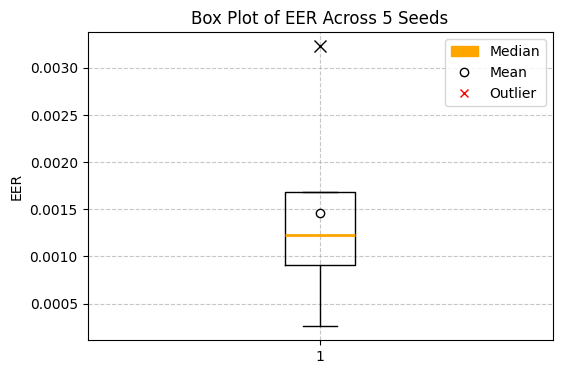

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create box plot with custom outlier and mean markers
flierprops = dict(marker='x', markerfacecolor='red', markersize=8, linestyle='none')
medianprops = dict(linewidth=2, color='orange')
meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6)

plt.figure(figsize=(6, 4))
box_plot = plt.boxplot(eer_list, 
                      flierprops=flierprops, 
                      medianprops=medianprops, 
                      showmeans=True, 
                      meanprops=meanprops)

# Create legend elements
median_line = mpatches.Patch(color='orange', label='Median')
mean_circle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
                        markeredgecolor='black', markersize=6, linestyle='', label='Mean')
outlier_x = plt.Line2D([0], [0], marker='x', color='red', linestyle='', label='Outlier')

# Add legend
plt.legend(handles=[median_line, mean_circle, outlier_x], loc='upper right')

plt.ylabel("EER")
plt.title("Box Plot of EER Across 5 Seeds")
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()   

/tmp/ipykernel_187598/13742594.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, flierprops=flierprops, medianprops=medianprops, showmeans=True, meanprops=meanprops, widths=0.5)


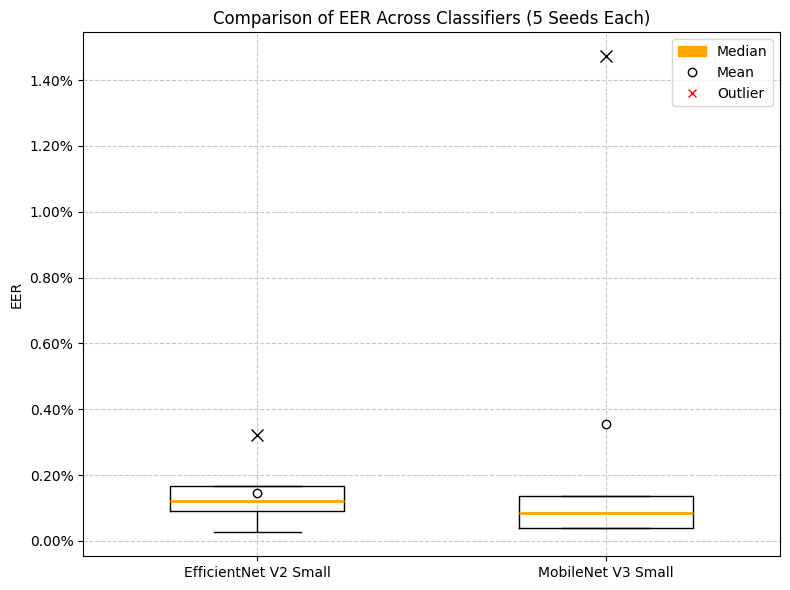

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import glob
import scipy.stats as st

# Read results for Classifier 1
files_clf1 = sorted(glob.glob("../src/predictions_effv2s*.csv"))
eer_clf1 = []
for file in files_clf1:
    df = pd.read_csv(file)
    fpr, tpr, _ = roc_curve(df["true_label"], df["predicted_score"])
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    eer_clf1.append(eer)

# Read results for Classifier 2
files_clf2 = sorted(glob.glob("../src/predictions_mobilev3s*.csv"))
eer_clf2 = []
for file in files_clf2:
    df = pd.read_csv(file)
    fpr, tpr, _ = roc_curve(df["true_label"], df["predicted_score"])
    fnr = 1 - tpr
    eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
    eer_clf2.append(eer)

# Create side-by-side box plot
data = [eer_clf1, eer_clf2]
labels = ['EfficientNet V2 Small', 'MobileNet V3 Small']

flierprops = dict(marker='x', markerfacecolor='red', markersize=8, linestyle='none')
medianprops = dict(linewidth=2, color='orange')
meanprops = dict(marker='o', markerfacecolor='white', markeredgecolor='black', markersize=6)

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=labels, flierprops=flierprops, medianprops=medianprops, showmeans=True, meanprops=meanprops, widths=0.5)   

# Add legend
median_line = mpatches.Patch(color='orange', label='Median')
mean_circle = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white',
                        markeredgecolor='black', markersize=6, linestyle='', label='Mean')
outlier_x = plt.Line2D([0], [0], marker='x', color='red', linestyle='', label='Outlier')
plt.legend(handles=[median_line, mean_circle, outlier_x], loc='upper right')

# Format y-axis as percentage
import matplotlib.ticker as mtick
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.ylabel("EER")
plt.title("Comparison of EER Across Classifiers (5 Seeds Each)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()   

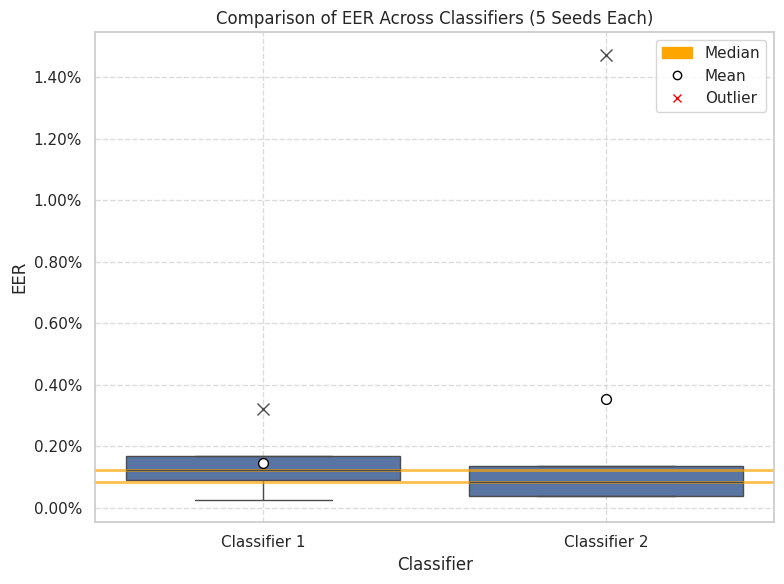

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data
data = [
    pd.DataFrame({'EER': eer_clf1, 'Classifier': 'Classifier 1'}),
    pd.DataFrame({'EER': eer_clf2, 'Classifier': 'Classifier 2'})
]
df_plot = pd.concat(data)

# Set style
sns.set_theme(style="whitegrid")

# Create box plot
plt.figure(figsize=(8, 6))
ax = sns.boxplot(x='Classifier', y='EER', data=df_plot, flierprops=dict(marker='x', markersize=8))

# Customize mean and median
medians = df_plot.groupby('Classifier')['EER'].median()
means = df_plot.groupby('Classifier')['EER'].mean()

for i, (median, mean) in enumerate(zip(medians, means)):
    ax.scatter(i, mean, color='white', edgecolor='black', s=50, zorder=3, label='Mean' if i == 0 else "")
    ax.axhline(median, color='orange', linewidth=2, alpha=0.7)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='orange', edgecolor='orange', label='Median'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=6, linestyle='', label='Mean'),
    plt.Line2D([0], [0], marker='x', color='red', linestyle='', label='Outlier')
]
ax.legend(handles=legend_elements, loc='upper right')

# Format y-axis as percentage
import matplotlib.ticker as mtick
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.title("Comparison of EER Across Classifiers (5 Seeds Each)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()   

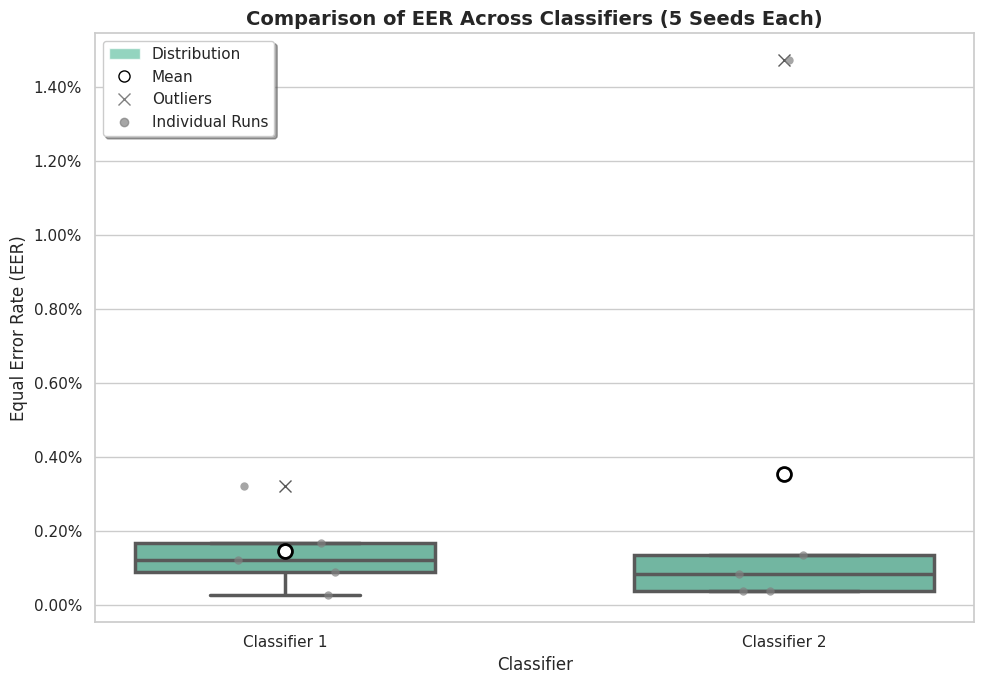

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as mtick

# Prepare data
data = [
    pd.DataFrame({'EER': eer_clf1, 'Classifier': 'Classifier 1'}),
    pd.DataFrame({'EER': eer_clf2, 'Classifier': 'Classifier 2'})
]
df_plot = pd.concat(data)

# Set style
sns.set_style("whitegrid")
sns.set_palette("Set2")

# Create figure with better sizing
plt.figure(figsize=(10, 7))
ax = sns.boxplot(x='Classifier', y='EER', data=df_plot, 
                 width=0.6, linewidth=2.5, flierprops={'marker': 'x', 'markersize': 8})

# Add raw data points for better visualization
sns.stripplot(x='Classifier', y='EER', data=df_plot, color='gray', 
              alpha=0.7, size=6, jitter=True, dodge=False, ax=ax)

# Calculate and plot mean and median
medians = df_plot.groupby('Classifier')['EER'].median()
means = df_plot.groupby('Classifier')['EER'].mean()

for i, (median, mean) in enumerate(zip(medians, means)):
    ax.scatter(i, mean, color='white', edgecolor='black', s=100, zorder=5, linewidth=2)

# Format y-axis as percentage
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

# Customize labels and title
plt.xlabel("Classifier", fontsize=12)
plt.ylabel("Equal Error Rate (EER)", fontsize=12)
plt.title("Comparison of EER Across Classifiers (5 Seeds Each)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Improve legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=sns.color_palette("Set2")[0], label='Distribution', alpha=0.7),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='white', 
               markeredgecolor='black', markersize=8, linestyle='', linewidth=2, label='Mean'),
    plt.Line2D([0], [0], marker='x', color='gray', linestyle='', markersize=8, label='Outliers'),
    plt.Line2D([0], [0], marker='o', color='gray', linestyle='', markersize=6, alpha=0.7, label='Individual Runs')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()   